## Train an RL agent
This notebook will focus the following topics:

- ### Introduction to RL with JEG
- ### Define featurize function
- ### Define reward function
- ### Training a single RL agent

## Introduction to RL with JEG

In the following, a reinforcement learning (RL) agent is trained to control the current flowing through an inductor.
It will be shown how the agent can learn and be applied to an simple electrical power grid simulated with de `JEG` package.

The use case is shown in the figure below.

![](figures/RL_single_agent.png "")

First we define the environment with the configuration shown in the figure. 
It consists of a single phase electrical power grid with 1 source and 1 load connected via a cable.
For more information on how to setup an environment see `Env_Create_DEMO.ipynb`.

The parameter dict is used for configuration.
Within the source dict, two imporant entires will have to be defined:
 - `"control_type"`: Defines whether the source is controlled applying a classic controller (`"classic"`) or using an RL agent (`"RL"`).
 - `"mode"`: Defines the control mode of controller/agent:
     - `"classic"`: Different predefined classic control modes can be chosen to apply a specific control behaviour (e.g., droop, VSG, step response,...). For more information see Classic_Controllers-notebooks or UserGuide.
     - `"RL"`: An agent name, which is used later on to link the defined agent to this source.
     
Here, `RL` is selected as `control_type` and the name `my_ddpg` as the `mode`. 


In [2]:
using JEG

In [3]:
# calculate passive load for some setting / power rating
R_load, L_load, X, Z = ParallelLoadImpedance(100e3, 1, 230)

# define grid using CM
CM = [0. 1.
    -1. 0.]

# Set parameters according to graphic above
parameters = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => 200e3, "control_type" => "RL", "mode" => "my_ddpg", "fltr" => "L"),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit"=>1e4, "i_limit"=>1e4),
                    ],
    "grid" => Dict{Any, Any}("phase" => 1)
);

In the following, the agent `my_ddpg` should learn to control the current of the source. Therefore, we define a reference value. The goal of the agent is to reach and track this reference signal. Using the `reward()` function, the agent receives feedback on the current state and the selected action.

Therefore, the reference value has to be defined. 
Here, we will use a constant value to keep the example simple.
But since the `reference(t)` function takes the simulation time as argument, more complex, time-dependent signals could be defined.

The reference for this example is to output $i_\mathrm{L1} = 1\,\mathrm{A}$:

In [4]:
function reference(t)
    return 1
end

reference (generic function with 1 method)

## Define featurize function

Afterwards the `featurize()` function, which gives the user the opportunity to modify the measured states before they get passed to the agent, is defined.

It takes three arguments:
- `state` contains all the state values that correspond to the source controlled by agent,
- `env` references the environment,
- `name` contains the key of the agent.

In the following, the signal generated by the `reference` function is added to the state provided to the agent `my_ddpg`. This will help the agent to learn because later we will define a reward that has maximum value if the measured current fits the reference value.
The reference value has to be normalized in an appropirate way that it fits to the range of the normalized states.

Additionally, more signals could be added here to enhance the learning process.

As stated before, `state` already contains all state values of the source the agent with key `name` should control.
However, the environment maintains a lot more states than that. Through `featurize` we could expose them to the agent but we refrain from that here since we want to simulate a scenario where the source the agent controls is far away (e.g. 1km) from the load its supplying. 
In cases like this it's common that the agent has no knowlegde about states of the load since no communication and measurements exchange between source and load is assumed.

In anonther example, the electrical power grid consits of multiple sources and loads. The other sources are controlled by other agents or classic controllers. In that case, typically every controller/agent has knowlegde of the states of the source it controls but not about the states another agent/controller controls.
Handing the corresponding source-depending states to the correct controllers/agents is handeled internally based on the `keys` (above: `my_ddpg`- for more information see `MultiController` and `inner_featurize` of the `env`).

In [5]:
featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end

#9 (generic function with 1 method)

## Define reward function

The `reward()` function provides a feedback to the agent on how good the chosen action was.
First, the state to be controlled is taken from the current environment state values.
Since the states are normalized by the limits the electrical components can handle, a value greater than `1` means that the state limit is exceeded typically leading to a system crash.
Therefore, first it is checked if the measured state is greater than `1`. In that case a punishment is returned which, here, is chosen to be `r = -1`.

In case the controlled state is within the valid state space, the reward is caculated based on the error between the wanted reference value and the measured state value. 
If these values are the same, meaning the agent perfectly fullfills the control task, a reward of `r = 1` is returned to the agent. ( -> r $\in$ [-1, 1]).
If the measured value differs from the reference, the error - based on the root-mean square error (RMSE) in this example - is substracted from the maximal reward: `r = 1 - RMSE`:

$r = 1 - \sqrt{\frac{|i_\mathrm{L,ref} - i_\mathrm{L1}|}{2}}$

To keep the reward in the wanted range, the current difference is devided by 2. 

In [6]:
function reward_function(env, name = nothing)
    if name == "my_ddpg"
        index_1 = findfirst(x -> x == "source1_i_L1", env.state_ids)
        state_to_control = env.state[index_1]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]          
            r = 1-((abs.(refs/norm_ref - state_to_control)/2).^0.5)
            return r 
        end
    end
end

reward_function (generic function with 2 methods)

## Training a single RL agent


Then, the defined parameters, featurize and reward functions are used to create an environment consisting of the electrical power grid. To keep the first learning example simple, the action given to the env is internally not delayed (as it would be in a real-world digitally controlled system). 

In [7]:
env = ElectricGridEnv(
    CM = CM, 
    parameters = parameters, 
    t_end = 0.1, 
    featurize = featurize_ddpg, 
    reward_function = reward_function, 
    action_delay = 0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In this example, a `Deep Deterministic Policy Gradient` agent (compare the corresponding [paper](https://arxiv.org/abs/1509.02971), or this nice [introdution](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)) is chosen which can learn a control task on continous state and action spaces.
It is configured using the `CreateAgentDdpg()` function:



In [8]:
agent = CreateAgentDdpg(na = length(env.agent_dict["my_ddpg"]["action_ids"]),
                          ns = length(state(env, "my_ddpg")),
                          use_gpu = false);

The environment stores the indices (states and actions) to which the agent has access based on the definition in the parameter dict.
This can be found in the  `agent_dict` using the defined agent name.

`env.agent_dict[chosen_name]` (chosen name, here, `my_ddpg`):
- `"source_number"`: ID/number of the source the agent with this key controls
- `"mode"`: Name of the agent
- `"action_ids"`: List of strings with the action ids the agent controls/belong to the `"source_number"`
- `"state_ids"`: List of strings with the state ids the agent controls/belong to the `"source_number"`

After defining the agent, the control side of the experiment is configured in the `SetupAgents()` method.
The function returns `controller` which is an instance of the `MultiController` that contains the different agents and classic controllers and maps their actions to the corresponding sources.


In [9]:
my_custom_agents = Dict("my_ddpg" => agent)

controller = SetupAgents(env, my_custom_agents);

To use the predefined agent in the experiment, the `SetupAgents()` takes a dictonary as secound input. Like shown above, the dictonary `my_custom_agents` links the predefined `agent` to the chosen agent name (`"mode"`) in the parameter dict.

Internally, the `SetupAgents()` function extends the `agent` by a name to a [named policy](https://juliareinforcementlearning.org/docs/rlcore/#ReinforcementLearningCore.NamedPolicy ).
Using this named policy the [MultiController](https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.MADDPGManager) enables to call the different agents/controllers via name during training and application.
This is used for example in the `reward()` function to return a specific reward to the `my_ddpg` agent (`if name == "my_ddpg" ...`)
Later, that functionality helps to give different rewards to different agents seperated by name.



Now, the agent can be trained for 20 episodes using the `Learn()`:

In [10]:
Learn(controller, env, num_episodes = 20);

Progress:  10%|█████                                    |  ETA: 0:06:40

Progress:  60%|█████████████████████████                |  ETA: 0:00:32

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:05

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
         825.706 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│ my_ddpg
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│        
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│        
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸│        
                 │⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇│        
                 │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇│        
                 │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇│        
   Score         │⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀│        
                 │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀│        
                 │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

The learning curve of accumulated reward per episode is printed to the command line/output window as shown above.

After the training, the `Simulate()` function is used to run a test epiode without action noise and the state to be controlled ($i_\mathrm{L1}$) is plotted:

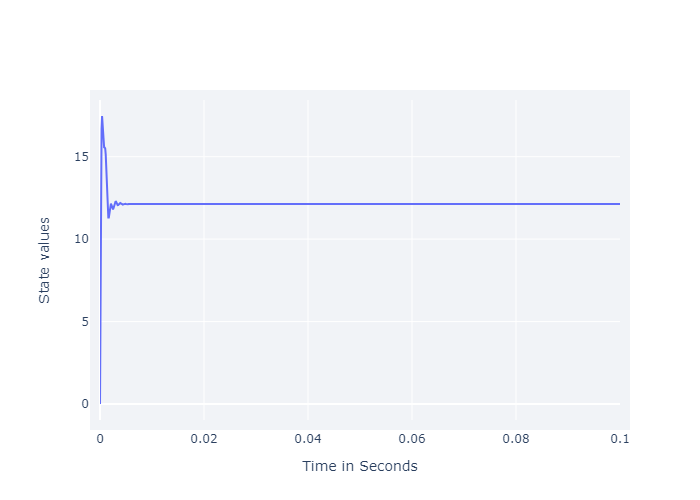

In [11]:
states_to_plot = ["source1_i_L1"]
hook = DataHook(collect_state_ids = states_to_plot)

Simulate(controller, env, hook=hook)

RenderHookResults(hook = hook,
                  states_to_plot  = states_to_plot)